## Tutorial 07 - Non linear Elliptic problem
**_Keywords: DEIM, POD-Galerkin_**

### 1. Introduction

In this tutorial, we consider a non linear elliptic problem in a two-dimensional spatial domain $\Omega=(0,1)^2$. We impose a homogeneous Dirichlet condition on the boundary $\partial\Omega$. The source term is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = 100\sin(2\pi x_0)cos(2\pi x_1) \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

This problem is characterized by two parameters. The first parameter $\mu_0$ controls the strength of the sink term and the second parameter $\mu_1$ the strength of the nonlinearity. The range of the two parameters is the following:
$$
\mu_0,\mu_1\in[0.01,10.0]
$$
The parameter vector $\boldsymbol{\mu}$ is thus given by
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.01,10]^2.
$$


In order to obtain a faster approximation of the problem, we pursue a model reduction by means of a POD-Galerkin reduced order method. In order to preserve the affinity assumption the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.



### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the solution in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$ -\nabla^2u(\boldsymbol{\mu})+\frac{\mu_0}{\mu_1}(\exp\{\mu_1u(\boldsymbol{\mu})\}-1)=g(\boldsymbol{x}; \boldsymbol{\mu})$$
<br>
    
The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)+c\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H_1(\Omega) : v|_{\partial\Omega}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized bilinear form $c(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$c(u, v;\boldsymbol{\mu})=\mu_0\int_{\Omega} \frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \int_{\Omega}g(\boldsymbol{x}; \boldsymbol{\mu})v \ d\boldsymbol{x}.$$

The output of interest $s(\boldsymbol{\mu})$ is given by
$$s(\boldsymbol{\mu}) = \int_{\Omega} v \ d\boldsymbol{x}$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np
import time

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{1}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)},$$
$$c(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{c}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega}\frac{1}{\mu_1}\big(\exp\{\mu_1u\} - 1\big)v \ d\boldsymbol{x}}_{c_0(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{100}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Omega}\sin(2\pi x_0)cos(2\pi x_1)v \ d\boldsymbol{x}}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class NonlinearElliptic(NonlinearEllipticProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$, $\Theta^{c}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $a_*(u, v)$, $c_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
@DEIM("online", basis_generation="Greedy")
@ExactParametrizedFunctions("offline")
class NonlinearElliptic(NonlinearEllipticProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearEllipticProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        self.u = self._solution
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Store the forcing term expression
        self.f = Expression("sin(2*pi*x[0])*sin(2*pi*x[1])", element=self.V.ufl_element())
        # Customize nonlinear solver parameters
        self._nonlinear_solver_parameters.update({
            "linear_solver": "mumps",
            "maximum_iterations": 20,
            "report": True
        })

    # Return custom problem name
    def name(self):
        return "NonlinearEllipticDEIM"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = 1.#mu[0]
            return (theta_a0,)
        elif term == "c":
            theta_c0 = mu[0]
            return (theta_c0,)
        elif term == "f":
            theta_f0 = 100.
            return (theta_f0,)
        elif term == "s":
            theta_s0 = 1.0
            return (theta_s0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            du = self.du
            a0 = inner(grad(du), grad(v)) * dx
            return (a0,)
        elif term == "c":
            u = self.u
            mu = self.mu
            c0 = (exp(mu[1] * u) - 1) / mu[1] * v * dx
            return (c0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "s":
            s0 = v * dx
            return (s0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1)]
            return (bc0,)
        elif term == "inner_product":
            du = self.du
            x0 = inner(grad(du), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearEllipticProblem)
def CustomizeReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
    class ReducedNonlinearElliptic(ReducedNonlinearElliptic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearElliptic_Base.__init__(self, truth_problem, **kwargs)
            self._nonlinear_solver_parameters.update({
                "report": True,
                "line_search": "wolfe"
            })

    return ReducedNonlinearElliptic

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/square.xml")
subdomains = MeshFunction("size_t", mesh, "data/square_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/square_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the NonlinearElliptic class

In [5]:
problem = NonlinearElliptic(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (0.1, 10.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(8, DEIM=8)#21
reduction_method.set_tolerance(0, DEIM=0)#1e-8, DEIM=1e-5)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100, DEIM=100)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \left\|A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)}) + \boldsymbol{c}(\boldsymbol{\mu}^{(i)})\right\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the bilinear form $a$, $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the linear form $f$, and $\boldsymbol{c}(\boldsymbol{\mu})$ is a vector corresponding to the nonlinear form $c$.

In [9]:
# build matrices for computing DEIM
selected_indices = sorted([idx[0] for idx in problem.DEIM_approximations['c'][0].interpolation_locations.get_dofs_list()])
U = np.array(problem._assemble_operator_DEIM('c')).T
P = []
for idx in selected_indices:
    new_column = np.zeros(U.shape[0])
    new_column[idx] = 1
    P.append(new_column)
P = np.array(P).T
PtUinv = np.linalg.inv(P.T @ U)

In [10]:
selected_indices = sorted([idx[0] for idx in problem.DEIM_approximations['c'][0].interpolation_locations.get_dofs_list()])
dx_test = torch.tensor(np.array(assemble(problem.v*dx))[selected_indices].reshape(-1, 1))
ones_tensor = torch.ones_like(dx_test)

def DEIM_nonlinearity(u, mu):
    """
    u: torch.tensor with shape (reduced order dimension, number of samples)
    mu: torch.tensor with shape (number of samples, number of parameters)
    """
    res = mu[:, 0].view(1, -1) / mu[:, 1].view(1, -1) * (torch.exp(mu[:, 1].view(1, -1) * torch.minimum(u, 20*ones_tensor)) - 1)
    return torch.matmul(torch.tensor(PtUinv[:, :]), dx_test * res)

In [18]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=60)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn, DEIM_func_c=DEIM_nonlinearity)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=60000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [19]:
pinn_trainer.train()

0:  |F(x)| = 1.24136; step 1
1:  |F(x)| = 0.180216; step 1
2:  |F(x)| = 0.00690687; step 1
3:  |F(x)| = 0.000166227; step 1
4:  |F(x)| = 6.11039e-06; step 1
5:  |F(x)| = 2.14636e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 2.58173; step 0.521607
1:  |F(x)| = 1.40884; step 0.431387
2:  |F(x)| = 0.169933; step 1
3:  |F(x)| = 0.00810881; step 1
4:  |F(x)| = 1.85772e-05; step 1
5:  |F(x)| = 7.41561e-08; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 4.79955; step 0.128162
1:  |F(x)| = 4.07274; step 0.150932
2:  |F(x)| = 3.21324; step 0.208541
3:  |F(x)| = 1.95445; step 0.37659
4:  |F(x)| = 0.386544; step 1
5:  |F(x)| = 0.0330789; step 1
6:  |F(x)| = 0.000294287; step 1
7:  |F(x)| = 8.13406e-07; step 1
scipy solver converged in 9 iterations.
0:  |F(x)| = 3.64002; step 0.327254
1:  |F(x)| = 2.36138; step 0.337255
2:  |F(x)| = 0.423577; step 1
3:  |F(x)| = 0.0325127; step 1
4:  |F(x)| = 0.000328133; step 1
5:  |F(x)| = 4.29405e-06; step 1
scipy solver converge

0:  |F(x)| = 3.21327; step 0.399259
1:  |F(x)| = 0.964359; step 1
2:  |F(x)| = 0.121878; step 1
3:  |F(x)| = 0.00356914; step 1
4:  |F(x)| = 6.93291e-05; step 1
5:  |F(x)| = 2.30336e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.70611; step 0.315112
1:  |F(x)| = 2.05651; step 0.398652
2:  |F(x)| = 0.245194; step 1
3:  |F(x)| = 0.0130037; step 1
4:  |F(x)| = 6.9512e-05; step 1
5:  |F(x)| = 1.56443e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.0100609; step 1
1:  |F(x)| = 0.000103006; step 1
2:  |F(x)| = 7.96551e-06; step 1
3:  |F(x)| = 6.44323e-07; step 1
scipy solver converged in 5 iterations.
0:  |F(x)| = 0.806876; step 1
1:  |F(x)| = 0.0843658; step 1
2:  |F(x)| = 0.0018333; step 1
3:  |F(x)| = 3.70748e-05; step 1
4:  |F(x)| = 9.50366e-07; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 2.50394; step 0.515175
1:  |F(x)| = 0.319422; step 1
2:  |F(x)| = 0.0179707; step 1
3:  |F(x)| = 0.000374245; step 1
4:  |F(x)| = 1.49817e-05; step

1:  |F(x)| = 2.15583; step 0.37944
2:  |F(x)| = 0.347239; step 1
3:  |F(x)| = 0.0250339; step 1
4:  |F(x)| = 0.000126924; step 1
5:  |F(x)| = 1.86236e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.595159; step 1
1:  |F(x)| = 0.0452929; step 1
2:  |F(x)| = 0.00360481; step 1
3:  |F(x)| = 0.000362209; step 1
4:  |F(x)| = 3.69789e-05; step 1
5:  |F(x)| = 3.78208e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.315798; step 1
1:  |F(x)| = 0.0173115; step 1
2:  |F(x)| = 0.00145338; step 1
3:  |F(x)| = 0.000136315; step 1
4:  |F(x)| = 1.28644e-05; step 1
5:  |F(x)| = 1.21502e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.64798; step 0.325623
1:  |F(x)| = 2.36741; step 0.337124
2:  |F(x)| = 0.422841; step 1
3:  |F(x)| = 0.0323169; step 1
4:  |F(x)| = 0.000327134; step 1
5:  |F(x)| = 4.35141e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 2.71878; step 0.480933
1:  |F(x)| = 0.45662; step 1
2:  |F(x)| = 0.0335238; step 1

2800 0.005623662705323408 	Loss(validation) = 0.003603628723207036
2900 0.005159639868018028 	Loss(validation) = 0.003254444721717895
3000 0.004775743074072366 	Loss(validation) = 0.0029855608302874403
3100 0.004453464982260074 	Loss(validation) = 0.002776774137744427
3200 0.004178086697646967 	Loss(validation) = 0.002611122959940526
3300 0.003938306013057581 	Loss(validation) = 0.0024753064900518485
3400 0.0037257024893573216 	Loss(validation) = 0.002359615191168581
3500 0.0035341132002055845 	Loss(validation) = 0.0022574677913017585
3600 0.003359084032186133 	Loss(validation) = 0.0021646857154701176
3700 0.003197362177374247 	Loss(validation) = 0.00207880402791586
3800 0.003046549871241742 	Loss(validation) = 0.001998428198169275
3900 0.0029048505957419467 	Loss(validation) = 0.0019228649053299207
4000 0.002770890620247391 	Loss(validation) = 0.0018517321533333784
4100 0.0026436037132552175 	Loss(validation) = 0.001784845164081375
4200 0.002522142083554891 	Loss(validation) = 0.00172

14600 2.8698856379794774e-05 	Loss(validation) = 6.85588489230701e-05
14700 2.8163567129035812e-05 	Loss(validation) = 6.754861548344473e-05
14800 2.81531249122005e-05 	Loss(validation) = 6.99547489643471e-05
14900 2.7537624521389604e-05 	Loss(validation) = 6.725081752631046e-05
15000 2.7021325365371016e-05 	Loss(validation) = 6.698370453685355e-05
15100 2.7053516105267806e-05 	Loss(validation) = 6.878016216771345e-05
15200 2.6443382431579305e-05 	Loss(validation) = 6.600686914065008e-05
15300 2.5994268551214553e-05 	Loss(validation) = 6.4806600561785e-05
15400 2.626607442613163e-05 	Loss(validation) = 6.439214963531845e-05
15500 2.5388918614801862e-05 	Loss(validation) = 6.486763882256717e-05
15600 0.00023065701438056783 	Loss(validation) = 0.00037329398654629357
15700 2.492109553661464e-05 	Loss(validation) = 6.45734848222418e-05
15800 2.4375588447148267e-05 	Loss(validation) = 6.378550266689108e-05
15900 2.462845972429226e-05 	Loss(validation) = 0.000175140859471425
16000 2.38533856

26200 1.017836039258843e-05 	Loss(validation) = 2.872480324669389e-05
26300 8.890035909770418e-06 	Loss(validation) = 3.054423006832454e-05
26400 8.755169041389803e-06 	Loss(validation) = 2.9843173424458932e-05
26500 8.659096034214553e-06 	Loss(validation) = 2.9538141490076333e-05
26600 1.6379795940602822e-05 	Loss(validation) = 2.8230823846301426e-05
26700 8.581493968943535e-06 	Loss(validation) = 2.915900691582453e-05
26800 8.485365323097722e-06 	Loss(validation) = 2.8840084623666674e-05
26900 8.678798435255907e-06 	Loss(validation) = 3.05494961067047e-05
27000 8.407160069391716e-06 	Loss(validation) = 2.866781549391729e-05
27100 8.598928124087626e-06 	Loss(validation) = 2.7192669112537018e-05
27200 8.391969286429125e-06 	Loss(validation) = 2.8329236089406098e-05
27300 8.251324892736315e-06 	Loss(validation) = 2.8148402859981237e-05
27400 1.0767087457800037e-05 	Loss(validation) = 3.71183165274927e-05
27500 8.20757691715393e-06 	Loss(validation) = 2.838940204967688e-05
27600 8.075353

37800 5.039814444024644e-06 	Loss(validation) = 1.7876409360437993e-05
37900 4.685315402028113e-06 	Loss(validation) = 1.6939036146465952e-05
38000 9.490442036730173e-05 	Loss(validation) = 6.797974297362722e-05
38100 4.655501053849201e-06 	Loss(validation) = 1.6798800683611803e-05
38200 4.608161231163167e-06 	Loss(validation) = 1.674069300535584e-05
38300 5.004540999817329e-06 	Loss(validation) = 1.781103007325447e-05
38400 4.585485899925653e-06 	Loss(validation) = 1.667563977226904e-05
38500 6.368542986015127e-06 	Loss(validation) = 1.676237708387417e-05
38600 4.590739848768236e-06 	Loss(validation) = 1.6941336728385016e-05
38700 4.51401536327429e-06 	Loss(validation) = 1.647779372318012e-05
38800 9.72075292724354e-06 	Loss(validation) = 2.5362187108995505e-05
38900 4.492819074367469e-06 	Loss(validation) = 1.6459565585668932e-05
39000 4.449301321349501e-06 	Loss(validation) = 1.6298407097843333e-05
39100 5.35098667469331e-06 	Loss(validation) = 1.68434517320697e-05
39200 4.423921003

49400 2.9702432566453855e-06 	Loss(validation) = 1.2594410464550915e-05
49500 2.9355363755715584e-06 	Loss(validation) = 1.2603284461323757e-05
49600 7.786834371528142e-06 	Loss(validation) = 2.8317909931203753e-05
49700 2.9248262092750155e-06 	Loss(validation) = 1.2549151099197439e-05
49800 2.9003424341508375e-06 	Loss(validation) = 1.2496269498709218e-05
49900 3.557159763678675e-06 	Loss(validation) = 1.2142752864744036e-05
50000 2.8879271319527344e-06 	Loss(validation) = 1.2485859140962342e-05
50100 1.1836370868167677e-05 	Loss(validation) = 2.2450690362659106e-05
50200 2.878562172424063e-06 	Loss(validation) = 1.2440913367661006e-05
50300 2.8532524244693237e-06 	Loss(validation) = 1.2388456926326649e-05
50400 5.811034886653099e-06 	Loss(validation) = 1.4594539693130578e-05
50500 2.8401084288822397e-06 	Loss(validation) = 1.2366126220486123e-05
50600 2.8207084196767095e-06 	Loss(validation) = 1.2356192014063556e-05
50700 2.9319527631251236e-06 	Loss(validation) = 1.2606013085922333e

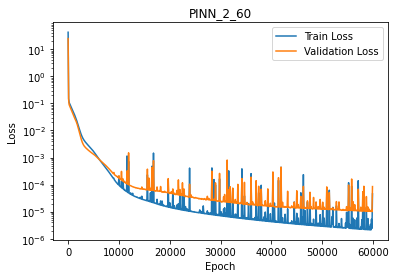

In [20]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [ ]:
input_normalization_pdnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.MinMaxNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [ ]:
pdnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W),$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [ ]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, num_epochs=1000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [ ]:
prnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [21]:
reduction_method.initialize_testing_set(100, DEIM=60)
#reduction_method.error_analysis()

False

#### 4.6.2 PINN Error Analysis

In [22]:
test_mu = torch.tensor(reduction_method.testing_set)

In [23]:
errors = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn, relative=True
)

0:  |F(x)| = 0.394212; step 1
1:  |F(x)| = 0.0190567; step 1
2:  |F(x)| = 0.000880559; step 1
3:  |F(x)| = 5.2079e-05; step 1
4:  |F(x)| = 3.13153e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 3.70135; step 0.322901
1:  |F(x)| = 2.21561; step 0.370285
2:  |F(x)| = 0.549721; step 1
3:  |F(x)| = 0.0609536; step 1
4:  |F(x)| = 0.000921454; step 1
5:  |F(x)| = 1.19093e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.67303; step 0.314248
1:  |F(x)| = 1.54025; step 0.509104
2:  |F(x)| = 0.0379531; step 1
3:  |F(x)| = 0.000660432; step 1
4:  |F(x)| = 6.50664e-06; step 1
5:  |F(x)| = 3.21102e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 4.03867; step 0.264622
1:  |F(x)| = 1.65166; step 1
2:  |F(x)| = 0.296205; step 1
3:  |F(x)| = 0.016783; step 1
4:  |F(x)| = 0.000333296; step 1
5:  |F(x)| = 1.4354e-05; step 1
6:  |F(x)| = 5.49098e-07; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 2.41106; step 0.535375
1:  |F(x)| = 0.343378

4:  |F(x)| = 7.28482e-05; step 1
5:  |F(x)| = 1.034e-05; step 1
6:  |F(x)| = 1.46783e-06; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 3.4657; step 0.357005
1:  |F(x)| = 1.50591; step 1
2:  |F(x)| = 0.259047; step 1
3:  |F(x)| = 0.0130297; step 1
4:  |F(x)| = 0.000130834; step 1
5:  |F(x)| = 4.39495e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 1.35616; step 1
1:  |F(x)| = 0.216832; step 1
2:  |F(x)| = 0.0093226; step 1
3:  |F(x)| = 0.000174528; step 1
4:  |F(x)| = 5.69636e-06; step 1
scipy solver converged in 6 iterations.
0:  |F(x)| = 1.89058; step 1
1:  |F(x)| = 0.343235; step 1
2:  |F(x)| = 0.0217073; step 1
3:  |F(x)| = 0.000751743; step 1
4:  |F(x)| = 4.41492e-05; step 1
5:  |F(x)| = 2.45963e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 2.98079; step 0.439385
1:  |F(x)| = 0.740162; step 1
2:  |F(x)| = 0.081946; step 1
3:  |F(x)| = 0.00176541; step 1
4:  |F(x)| = 2.94179e-05; step 1
5:  |F(x)| = 7.97182e-07; step 1
scipy solver 

1:  |F(x)| = 2.41403; step 0.325485
2:  |F(x)| = 0.393784; step 1
3:  |F(x)| = 0.0287992; step 1
4:  |F(x)| = 0.000216782; step 1
5:  |F(x)| = 2.85821e-06; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 3.70587; step 0.319778
1:  |F(x)| = 1.97167; step 0.423683
2:  |F(x)| = 0.240925; step 1
3:  |F(x)| = 0.0129015; step 1
4:  |F(x)| = 4.14393e-05; step 1
5:  |F(x)| = 5.71371e-07; step 1
scipy solver converged in 7 iterations.
0:  |F(x)| = 0.0805712; step 1
1:  |F(x)| = 0.000435473; step 1
2:  |F(x)| = 9.89234e-07; step 1
scipy solver converged in 4 iterations.
0:  |F(x)| = 4.207; step 0.235049
1:  |F(x)| = 2.62447; step 0.366722
2:  |F(x)| = 0.640869; step 1
3:  |F(x)| = 0.0735278; step 1
4:  |F(x)| = 0.00137461; step 1
5:  |F(x)| = 9.8221e-06; step 1
6:  |F(x)| = 1.52031e-07; step 1
scipy solver converged in 8 iterations.
0:  |F(x)| = 0.303829; step 1
1:  |F(x)| = 0.0189419; step 1
2:  |F(x)| = 0.00198217; step 1
3:  |F(x)| = 0.000226294; step 1
4:  |F(x)| = 2.59794e-05; s

  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 8.588561e-01
  2 SNES Function norm 2.404358e-01
  3 SNES Function norm 2.988763e-02
  4 SNES Function norm 5.398518e-04
  5 SNES Function norm 1.828867e-07
  6 SNES Function norm 2.169189e-14
PETSc SNES solver converged in 6 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 6.984613e-02
  2 SNES Function norm 2.635570e-03
  3 SNES Function norm 2.999618e-06
  4 SNES Function norm 3.783281e-12
PETSc SNES solver converged in 4 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 2.008055e-01
  2 SNES Function norm 1.584474e-02
  3 SNES Function norm 9.876424e-05
  4 SNES Function norm 3.834779e-09
  5 SNES Function norm 3.984064e-15
PETSc SNES solver converged in 5 iterations with convergence reason 2.
  0 SNES Function norm 1.510614e+00
  1 SNES Function norm 1.358658e+00
  2 SNES Function norm 1.220638e+00
  3 SNES Function norm 1.095892

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (5., 5.), input_normalization_pinn, output_normalization_pinn, colorbar=True
)

#### 4.6.3 PDNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn, relative=True
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (5., 5.), input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn, relative=False
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (5., 5.), input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [ ]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, relative=False
)

### 4.7. Perform a speedup analysis

In [ ]:
reduction_method.speedup_analysis()